In [3]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()
using Ferrite, SparseArrays, LinearAlgebra
using FerriteGmsh
using PyCall
using Plots
using LaTeXStrings
include("reactive_stats_struct.jl")
include("commonitors.jl")

function trans_stat(result_loc::Vector{Vector{Float64}}, base_info::grid_info, react_stat::reactive_stat, length::Int64)
    points = [Vec((x, y)) for y in range(result_loc[2][1], result_loc[2][2], length=length) for x in range(result_loc[1][1],result_loc[1][2],length = length)];
    ph_stat = PointEvalHandler(base_info.grid_stat, points, warn = false);
    ph_comm = PointEvalHandler(base_info.grid_comm, points, warn = false);

    u_points_stat = Ferrite.get_point_values(ph_stat, base_info.dh_stat, react_stat.u_stat, :u);
    u_points_forward = Ferrite.get_point_values(ph_comm, base_info.dh_comm, react_stat.u_forward, :u);
    u_points_back = Ferrite.get_point_values(ph_comm, base_info.dh_comm, react_stat.u_backward, :u);

    distribution_points = get_point_values(ph_comm, L2Projector(base_info.ip, base_info.grid_comm), react_stat.reactive_density);
    distribution_points = permutedims(hcat(distribution_points...));

    current_points = get_point_values(ph_comm, L2Projector(base_info.ip, base_info.grid_comm), react_stat.reactive_current);
    current_points = permutedims(hcat(current_points...));

    return u_points_forward, u_points_back, u_points_stat, distribution_points, current_points
end

function obtain_TPT(grid_loc::Vector{Vector{Float64}}, range_loc::Vector{Vector{Float64}}, 
    g::Vector{Function}, D::Matrix{Function})
    #initialize the information of grid 
    base_info = grid_info();

    base_info.grid_stat = create_rect_mesh(grid_loc[1],grid_loc[2], grid_loc[3], grid_loc[4]);
    base_info.dh_stat = create_dofhandler(base_info.grid_stat);
    #implement the information of boundary conditions, and diffusion matrix 
    implement_grid(base_info, D, g)
    #initialize the reactive statistics 
    react_stat = reactive_stat();
    compute_stat_dist(base_info, react_stat)
    implement_grid(range_loc,grid_loc, base_info, react_stat)

    obtain_commonitor(base_info, react_stat);
    return base_info, react_stat
end


function export_result(base_info::grid_info, react_stat::reactive_stat, 
    stat_loc::Vector{Vector{Float64}}, current_loc::Vector{Vector{Float64}}, level::Int64)
    mfpt = react_stat.Z_normalization /react_stat.transition_rate
    _,_ ,_ ,_ , current_points = trans_stat(current_loc, base_info, react_stat, level);
    _,_ ,u_points_stat , distribution_points, _ = trans_stat(stat_loc, base_info, react_stat, 200);
    return react_stat.transition_rate, mfpt, u_points_stat, distribution_points, current_points
end

function export_committor(base_info::grid_info, react_stat::reactive_stat, stat_loc::Vector{Vector{Float64}})
    forward_u,backward_u ,_ ,_ , _ = trans_stat(stat_loc, base_info, react_stat, 200);
    return forward_u, backward_u
end

function arrow0!(x, y, u, v; as=0.1, lw=1, lc=:black, la=1)
    nuv = sqrt(u^2 + v^2)
    v1, v2 = [u;v] / nuv,  [-v;u] / nuv
    v4 = (3*v1 + v2)/3.1623  # sqrt(10) to get unit vector
    v5 = v4 - 2*(v4'*v2)*v2
    v4, v5 = as*nuv*v4, as*nuv*v5
    plot!([x,x+u], [y,y+v], lw=lw, lc=lc, la=la, label = false)
    plot!([x+u,x+u-v5[1]], [y+v,y+v-v5[2]], lw=lw, lc=lc, la=la, label = false)
    plot!([x+u,x+u-v4[1]], [y+v,y+v-v4[2]], lw=lw, lc=lc, la=la, label = false)
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

  Activating project at `~/Desktop/tpt_code`


meshgrid (generic function with 1 method)

In [4]:
#drift function
g1(x) = -x[1]^3+x[1]; g2(x) = -x[2];
g = [g1, g2]

2-element Vector{Function}:
 g1 (generic function with 1 method)
 g2 (generic function with 1 method)

In [5]:
x = range(-1.5, 1.5, length=10);y = range(-1.0, 1.0, length=10);
x_mesh, y_mesh = meshgrid(x, y)
x = range(-1.8, 1.8, length=200);y = range(-1.5, 1.5, length=200);

In [6]:
sigma = 0.6
D11(x) = sigma^2; D12(x) = 0 ;D21(x) = 0 ; D22(x) = sigma^2;
D = [D11 D12;D21 D22];
grid_loc = [[-2.5, -2.5],[-2.5,2.5],[2.5, -2.5],[2.5,2.5]];
range_loc = [[-1.8, -1.6],[0,1.6],[0,-1.6],[1.8,1.6]]; # find attracting states in this region 
stat_loc = [[-1.75,1.75],[-1.5,1.5]]; #density region 
curr_loc = [[-1.2,1.2],[-0.8,0.8]]; # current region 
level = 7
base_info, react_stat = obtain_TPT(grid_loc, range_loc, g, D);
rate_add1, mfpt_add1, stat_dist_add1, react_dist_add1, react_current_add1 = export_result(base_info, react_stat, stat_loc, curr_loc, level)
q_p1, q_m1 = export_committor(base_info, react_stat, stat_loc)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000595s, CPU 0.000305s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.25916s, CPU 0.25333s)
Info    : 11823 nodes 23648 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 9 (Ellipse)
Info    : [ 20%] Meshing curve 10 (Ellipse)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : Done meshing 1D (Wall 0.000486917s, CPU 0.000404s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.211828s, CPU 0.207027s)
Info    : 11916 nodes 23840 elements


([0.04677994044503232, 0.04698360984499517, 0.04720418942800615, 0.047425108041867885, 0.047660097907411325, 0.047904507377876396, 0.048147064923353036, 0.0484143839175783, 0.0486822714162478, 0.04896271103345126  …  0.9478062022658662, 0.9480816890789938, 0.9483535596829802, 0.9486205751642527, 0.9488685524249079, 0.9491165296855628, 0.9493481781644417, 0.9495724339802277, 0.9497927256667298, 0.9499969705773749], [0.9531090270848566, 0.9529229112133325, 0.9527184400440097, 0.9525133743316283, 0.9522923679698156, 0.9520614125148337, 0.9518324321779157, 0.9515766687824418, 0.9513201672358688, 0.95105059649708  …  0.05219187771962344, 0.051927371080535675, 0.05166661694554671, 0.05141103008882401, 0.05117605687965662, 0.050941083670489246, 0.05072383211454632, 0.05051513322994938, 0.05031092701224363, 0.050124411186684995])

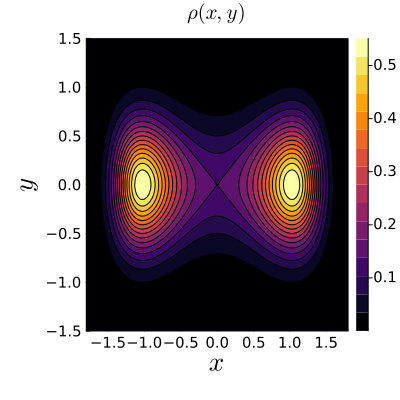

In [7]:
#stationary density 
contourf(x,y,stat_dist_add1, title = L"\rho(x,y)", xlab = L"x", ylab = L"y", size = (400,400),ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18))


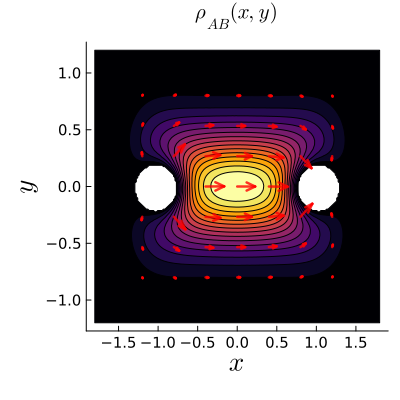

In [8]:
x = range(-1.2, 1.2, length=7);y = range(-0.8, 0.8, length=7);#meshgrid for current 
x_mesh, y_mesh = meshgrid(x, y); #meshgrid for current 
x = range(-1.8, 1.8, length=200);y = range(-1.2, 1.2, length=200);#grid for reactive density 
p1 = contourf(x,y,react_dist_add1[:,1], title = L"\rho_{AB}(x,y)", xlab = L"x", ylab = L"y", size = (400,400), clim = (0, 0.6), legend = false,ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18), grid = false)
arrow0!.(x_mesh, y_mesh, react_current_add1[:,1].*10, react_current_add1[:,2].*10; as=0.5, lw=2.5,lc=:red, la=0.8);
Plots.current()

In [9]:
sigma = 0.6
D11(x) = sigma^2*(x[1]^4 - x[1]^2+1)^2; D12(x) = 0 ;D21(x) = 0; D22(x) = sigma^2;
D = [D11 D12;D21 D22];
grid_loc = [[-2.5, -2.5],[-2.5,2.5],[2.5, -2.5],[2.5,2.5]];
range_loc = [[-1.8, -1.6],[0,1.6],[0,-1.6],[1.8,1.6]];
stat_loc = [[-1.75,1.75],[-1.5,1.5]];
curr_loc = [[-1.2,1.2],[-0.8,0.8]];
level = 7
base_info, react_stat = obtain_TPT(grid_loc, range_loc, g, D);
tp1_mul_rate1, tp1_mul_mfpt1, tp1_mul_stat1, tp1_mul_distribution1, tp1_mul_current1 = export_result(base_info, react_stat, stat_loc, curr_loc, level);

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000282833s, CPU 0.000273s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.261174s, CPU 0.259237s)
Info    : 11823 nodes 23648 elements
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 9 (Ellipse)
Info    : [ 20%] Meshing curve 10 (Ellipse)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : Done meshing 1D (Wall 0.000457458s, CPU 0.000383s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.196105s, CPU 0.192429s)
Info    : 11910 nodes 23828 elements


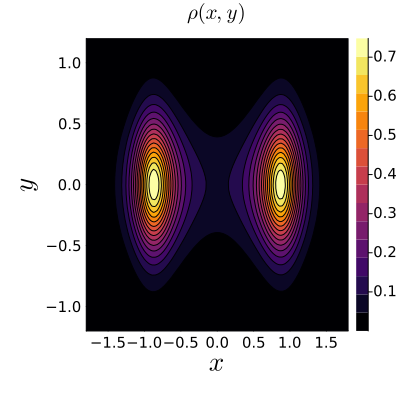

In [10]:
x = range(-1.2, 1.2, length=7);y = range(-0.8, 0.8, length=7);
x_mesh, y_mesh = meshgrid(x, y);
x = range(-1.8, 1.8, length=200);y = range(-1.2, 1.2, length=200);
contourf(x,y,tp1_mul_stat1, title = L"\rho(x,y)", xlab = L"x", ylab = L"y", size = (400,400),ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18))

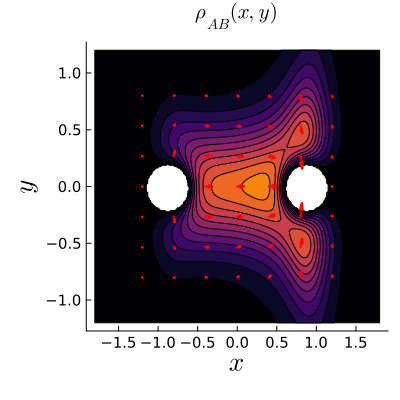

In [11]:
p1 = contourf(x,y,tp1_mul_distribution1[:,1], title = L"\rho_{AB}(x,y)", xlab = L"x", ylab = L"y", size = (400,400), clim = (0, 0.6), legend = false,ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18), grid = false)
arrow0!.(x_mesh, y_mesh, tp1_mul_current1[:,1].*5, tp1_mul_current1[:,2].*5; as=0.5, lw=2.5,lc=:red, la=0.8);
Plots.current()